# Analysis of Experiment 1 (Neuroscience)
In this notebook I will walk through the analysis I did for the first Experiment. There are 5 major sections:
* Preperation and First Look
* Good vs Bad Explanations
* Long vs Short Explanations
* Neuro Science Jargon vs No Neuro science jargon
* Analysis Combined

## Preperation and First Look
Here I will load the data, and make sure it makes sense

In [3]:
#Modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy.stats import ttest_ind
from utils_openAI import *

In [12]:
#read data
df = pd.read_csv('NeuroExp1b2.csv')
df.shape
df.head()

,Unnamed: 0,Condition,Stimulous,Answer Good,Answer
0,0,With Neuroscience Long,0,True,2
1,0,With Neuroscience Long,2,False,-2
2,0,Without Neuroscience Short,1,True,3
3,0,With Neuroscience Short,0,False,-2
4,0,Without Neuroscience Long,2,False,-2


In [10]:
#get the value count of the different conditions
print(df['Condition'].value_counts())
#get value counts of stimulous
print(df['Stimulous'].value_counts())
#get value counts of answer good
print(df['Answer Good'].value_counts())

With Neuroscience Long        108
Without Neuroscience Short    101
With Neuroscience Short        96
Without Neuroscience Long      95
Name: Condition, dtype: int64
0    147
2    130
1    123
Name: Stimulous, dtype: int64
True     205
False    195
Name: Answer Good, dtype: int64


Seems balanced enough, so that is good. Next I will transform the data so I can use it for numerical analysis

In [34]:
#Basic Data cleaning
df = df[['Condition', 'Answer', 'Stimulous', 'Answer Good']] #only keep vars of interest
df['Answer Good'] = df['Answer Good'].astype(int) #recode good bad to numeric dummy variable 0 bad, 1 good
df['Long'] = df['Condition'].str.contains('Long')#create a variable that is one if the condition contains the word long
df['Long'] = df['Long'].astype(int) #make numeric
df['NoNeuro'] = df['Condition'].str.contains('Without')#create a variable that is one if the condition contains the word without, means it is the no neuroscien condition
df['NoNeuro'] = df['NoNeuro'].astype(int) 
df_ohe = pd.get_dummies(df, columns = ['Condition']) #One hot encode conditions in seperate df
print(df_ohe.head())



   Answer  Stimulous  Answer Good  Long  NoNeuro  \
0       2          0            1     1        0   
1      -2          2            0     1        0   
2       3          1            1     0        1   
3      -2          0            0     0        0   
4      -2          2            0     1        1   

   Condition_With Neuroscience Long  Condition_With Neuroscience Short  \
0                                 1                                  0   
1                                 1                                  0   
2                                 0                                  0   
3                                 0                                  1   
4                                 0                                  0   

   Condition_Without Neuroscience Long  Condition_Without Neuroscience Short  
0                                    0                                     0  
1                                    0                                     0  
2    

count    400.000000
mean       0.555000
std        2.145573
min       -3.000000
25%       -2.000000
50%        2.000000
75%        2.000000
max        3.000000
Name: Answer, dtype: float64


<AxesSubplot:>

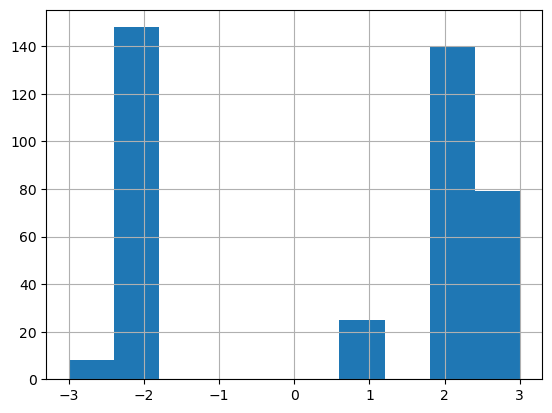

In [17]:
#get summary statistics of Answer variable
print(df['Answer'].describe())
#create histogram of the answer
df['Answer'].hist()

Ranges from -3 to +3 just as wanted. Mean around 0, sd pretty high. Extreme values are much more prominent than middle values. 

## Good vs Bad Explanations
In this section I will look at whether GPT favored good vs bad explanations. To reiterate, the difference is that the good answer provides some mechanistic explanation of what is going on, while the bad explanations were "circular restatements of the phenomenon with no mechanistic information that could give a reason for the phenomenon".

In [18]:
#compare the mean of answer good true and false for Answer
print(df.groupby('Answer Good')['Answer'].mean())
#get std of answer good true and false for Answer
print(df.groupby('Answer Good')['Answer'].std())

Answer Good
0   -0.338462
1    1.404878
Name: Answer, dtype: float64
Answer Good
0    2.107500
1    1.814153
Name: Answer, dtype: float64


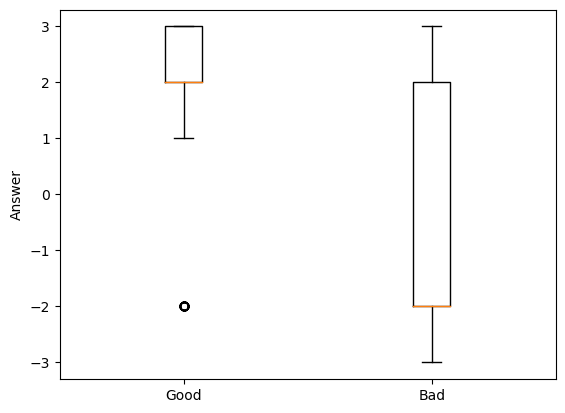

In [35]:
#get all good values and all bad values from Answer in seperate np arrays
good = df[df['Answer Good'] == True]['Answer'].values
bad = df[df['Answer Good'] == False]['Answer'].values
#make a boxplot of the two arrays
plt.boxplot([good, bad])
plt.xticks([1, 2], ['Good', 'Bad'])
plt.ylabel('Answer')
plt.show()

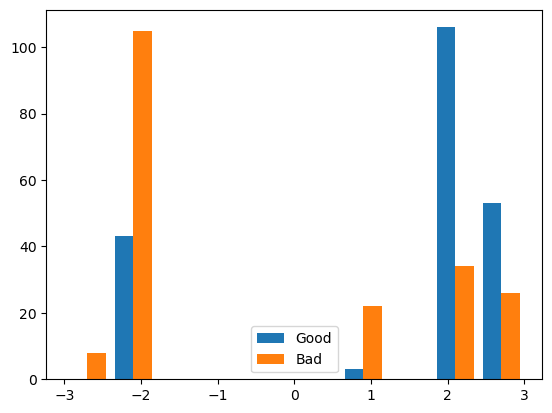

In [36]:
#bar plot of the counts of good and bad answers
plt.hist([good, bad], label = ['Good', 'Bad'])
plt.legend()
plt.show()


We can already see a clear difference between good and bad means. Let's further dig into this. I will run a t-test to see if the difference is significant. I will also run a regression, even though it is the same as  a t-test with one predictor. I am doing this because I will run more regressions later that will have more predictors.

In [55]:
#t-test for difference in means
ttest_good_bad = ttest_ind(df[df['Answer Good'] == 1]['Answer'], df[df['Answer Good'] == 0]['Answer'])
#regression for difference in means
x = df['Answer Good']
y = df['Answer']
x = sm.add_constant(x)
reg_good_bad = sm.OLS(y, x).fit(cov_type = 'HC3')
#print answer
print(ttest_good_bad)
print(reg_good_bad.summary())


Ttest_indResult(statistic=8.879912073625647, pvalue=2.3197038055846684e-17)
                            OLS Regression Results                            
Dep. Variable:                 Answer   R-squared:                       0.165
Model:                            OLS   Adj. R-squared:                  0.163
Method:                 Least Squares   F-statistic:                     77.87
Date:                Mon, 01 May 2023   Prob (F-statistic):           3.51e-17
Time:                        13:15:01   Log-Likelihood:                -836.29
No. Observations:                 400   AIC:                             1677.
Df Residuals:                     398   BIC:                             1685.
Df Model:                           1                                         
Covariance Type:                  HC3                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------

Overall, GPT clearly likes the good explanations significantly more than the bad exlanations. Let's see if this is true for each of the 4 conditions.

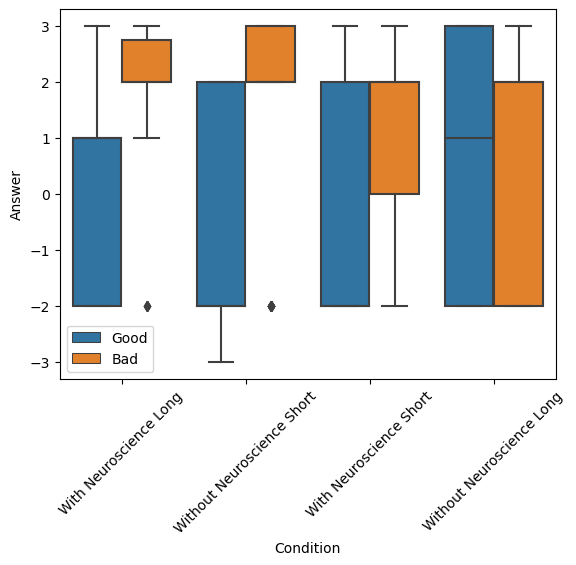

In [37]:
#get boxplots of the different conditions and answer good
sns.boxplot(x = 'Condition', y = 'Answer', hue = 'Answer Good', data = df)
#rotate x labels
plt.xticks(rotation = 45)
#change the text in ledged from True and False to Good and Bad while keeping the colors
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles, ['Good', 'Bad'])

plt.show()

In [56]:
c1 = df[df['Condition'] == 'Without Neuroscience Short']
c2 = df[df['Condition'] == 'Without Neuroscience Long']
c3 = df[df['Condition'] == 'With Neuroscience Short']
c4 = df[df['Condition'] == 'With Neuroscience Long']

#run a regression for each condition
x = c1['Answer Good']
y = c1['Answer']
x = sm.add_constant(x)
reg_c1 = sm.OLS(y, x).fit(cov_type = 'HC3')

x = c2['Answer Good']
y = c2['Answer']
x = sm.add_constant(x)
reg_c2 = sm.OLS(y, x).fit(cov_type = 'HC3')

x = c3['Answer Good']
y = c3['Answer']
x = sm.add_constant(x)
reg_c3 = sm.OLS(y, x).fit(cov_type = 'HC3')

x = c4['Answer Good']
y = c4['Answer']
x = sm.add_constant(x)
reg_c4 = sm.OLS(y, x).fit(cov_type = 'HC3')

print('----------Without Neuro Science Short----------')
print(reg_c1.summary())
print('----------Without Neuro Science Long----------')
print(reg_c2.summary())
print('----------With Neuro Science Short----------')
print(reg_c3.summary())
print('----------With Neuro Science Long----------')
print(reg_c4.summary())

----------Without Neuro Science Short----------
                            OLS Regression Results                            
Dep. Variable:                 Answer   R-squared:                       0.250
Model:                            OLS   Adj. R-squared:                  0.242
Method:                 Least Squares   F-statistic:                     32.13
Date:                Mon, 01 May 2023   Prob (F-statistic):           1.43e-07
Time:                        13:15:22   Log-Likelihood:                -210.96
No. Observations:                 101   AIC:                             425.9
Df Residuals:                      99   BIC:                             431.1
Df Model:                           1                                         
Covariance Type:                  HC3                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
co

Only in the Without Neuroscience Long condition did GPT not rate the good answers significantly higher. This is consistent with what we can see in the boxplot above.

## Long vs Short Explanations
In this section I will look at whether GPT favored long vs short explanations. 

In [38]:
#compare values
#compare the mean of answer good true and false for Answer
print(df.groupby('Long')['Answer'].mean())
#get std of answer good true and false for Answer
print(df.groupby('Long')['Answer'].std())

Long
0    0.269036
1    0.832512
Name: Answer, dtype: float64
Long
0    2.223186
1    2.034730
Name: Answer, dtype: float64


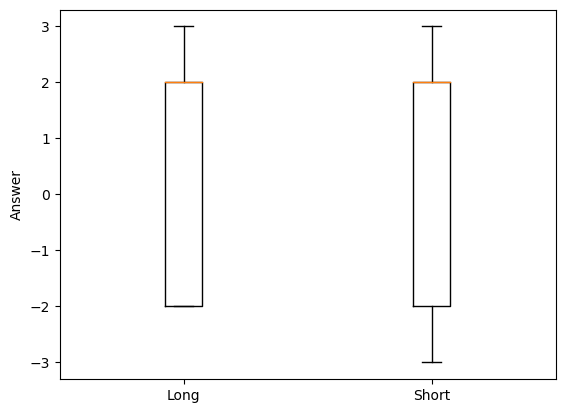

In [40]:
#get all good values and all bad values from Answer in seperate np arrays
Long = df[df['Long'] == 1]['Answer'].values
Short = df[df['Long'] == 0]['Answer'].values
#make a boxplot of the two arrays
plt.boxplot([Long, Short])
plt.xticks([1, 2], ['Long', 'Short'])
plt.ylabel('Answer')
plt.show()

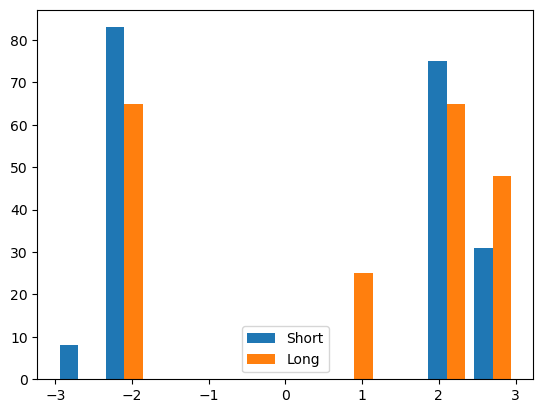

In [42]:
#bar plot of the counts of good and bad answers
plt.hist([Short, Long], label = ['Short', 'Long'])
plt.legend()
plt.show()

Much less difference based on the length of the explanation. No clear preference visible from the graph.

In [57]:
#t-test for difference in means
ttest_good_bad = ttest_ind(df[df['Long'] == 1]['Answer'], df[df['Long'] == 0]['Answer'])
#regression for difference in means
x = df['Long']
y = df['Answer']
x = sm.add_constant(x)
reg_long_short = sm.OLS(y, x).fit(cov_type = 'HC3')
#print answer
print(ttest_good_bad)
print(reg_long_short.summary())

Ttest_indResult(statistic=2.6456019188745814, pvalue=0.008477688576972588)
                            OLS Regression Results                            
Dep. Variable:                 Answer   R-squared:                       0.017
Model:                            OLS   Adj. R-squared:                  0.015
Method:                 Least Squares   F-statistic:                     6.946
Date:                Mon, 01 May 2023   Prob (F-statistic):            0.00873
Time:                        13:15:45   Log-Likelihood:                -868.95
No. Observations:                 400   AIC:                             1742.
Df Residuals:                     398   BIC:                             1750.
Df Model:                           1                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------

Seems like there is a significant difference after all, with Long explanations being rated around 0.56 higher on average than short answers. However, the very low R2 demonstrates how little of the variance this model explains (only 1.7%). Let's see if this is true for both for good and bad explanations

In [58]:
Good = df[df['Answer Good'] == 1]
Bad = df[df['Answer Good'] == 0]

#run a regression for each condition
x = Good['Long']
y = Good['Answer']
x = sm.add_constant(x)
reg_long_good = sm.OLS(y, x).fit(cov_type = 'HC3')

x = Bad['Long']
y = Bad['Answer']
x = sm.add_constant(x)
reg_long_bad = sm.OLS(y, x).fit(cov_type = 'HC3')

print('----------Good----------')
print(reg_long_good.summary())
print('----------Bad----------')
print(reg_long_bad.summary())

----------Good----------
                            OLS Regression Results                            
Dep. Variable:                 Answer   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.004
Method:                 Least Squares   F-statistic:                    0.2154
Date:                Mon, 01 May 2023   Prob (F-statistic):              0.643
Time:                        13:16:02   Log-Likelihood:                -412.37
No. Observations:                 205   AIC:                             828.7
Df Residuals:                     203   BIC:                             835.4
Df Model:                           1                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.3434      

Seems to only hold for Bad explanations, for good explanations there does not seem to be a significant effect of length. Let's check if the neuro science jargon makes a difference.

In [59]:
Neuro = df[df['NoNeuro'] == 0]
NoNeuro = df[df['NoNeuro'] == 1]

#run a regression for each condition
x = Neuro['Long']
y = Neuro['Answer']
x = sm.add_constant(x)
reg_long_Neuro = sm.OLS(y, x).fit(cov_type = 'HC3')

x = NoNeuro['Long']
y = NoNeuro['Answer']
x = sm.add_constant(x)
reg_long_NoNeuro = sm.OLS(y, x).fit(cov_type = 'HC3')

print('----------Neuro Science----------')
print(reg_long_Neuro.summary())
print('----------No Neuro Science----------')
print(reg_long_NoNeuro.summary())

----------Neuro Science----------
                            OLS Regression Results                            
Dep. Variable:                 Answer   R-squared:                       0.043
Model:                            OLS   Adj. R-squared:                  0.038
Method:                 Least Squares   F-statistic:                     8.780
Date:                Mon, 01 May 2023   Prob (F-statistic):            0.00341
Time:                        13:16:21   Log-Likelihood:                -432.60
No. Observations:                 204   AIC:                             869.2
Df Residuals:                     202   BIC:                             875.8
Df Model:                           1                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1

The effect is present for the Neuro science conditions, but not for the one without. So if it is not including neuro science jargon then GPT does not care about the length of the explanation. Lets look last at the neuro condition split by good and bad. 

In [60]:
Neuro_good = Neuro[Neuro['Answer Good'] == 1]
Neuro_bad = Neuro[Neuro['Answer Good'] == 0]
NoNeuro_good = NoNeuro[NoNeuro['Answer Good'] == 1]
NoNeuro_bad = NoNeuro[NoNeuro['Answer Good'] == 0]

#run a regression for each condition
x = Neuro_good['Long']
y = Neuro_good['Answer']
x = sm.add_constant(x)
reg_long_Neuro_good = sm.OLS(y, x).fit(cov_type = 'HC3')

x = Neuro_bad['Long']
y = Neuro_bad['Answer']
x = sm.add_constant(x)
reg_long_Neuro_bad = sm.OLS(y, x).fit(cov_type = 'HC3')

x = NoNeuro_good['Long']
y = NoNeuro_good['Answer']
x = sm.add_constant(x)
reg_long_NoNeuro_good = sm.OLS(y, x).fit(cov_type = 'HC3')

x = NoNeuro_bad['Long']
y = NoNeuro_bad['Answer']
x = sm.add_constant(x)
reg_long_NoNeuro_bad = sm.OLS(y, x).fit(cov_type = 'HC3')

print('----------Neuro Science Good----------')
print(reg_long_Neuro_good.summary())
print('----------Neuro Science Bad----------')
print(reg_long_Neuro_bad.summary())
print('----------No Neuro Science Good----------')
print(reg_long_NoNeuro_good.summary())
print('----------No Neuro Science Bad----------')
print(reg_long_NoNeuro_bad.summary())

#compare values



----------Neuro Science Good----------
                            OLS Regression Results                            
Dep. Variable:                 Answer   R-squared:                       0.053
Model:                            OLS   Adj. R-squared:                  0.044
Method:                 Least Squares   F-statistic:                     5.155
Date:                Mon, 01 May 2023   Prob (F-statistic):             0.0253
Time:                        13:17:02   Log-Likelihood:                -195.16
No. Observations:                 105   AIC:                             394.3
Df Residuals:                     103   BIC:                             399.6
Df Model:                           1                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        

Exists in all conditions except for -No Neuro Science Good

## Neuro Science Jargon vs No Neuro science jargon
In this section I will look into the effect of neuro science Jargon

In [61]:
#compare values
#compare the mean of answer good true and false for Answer
print(df.groupby('NoNeuro')['Answer'].mean())
#get std of answer good true and false for Answer
print(df.groupby('NoNeuro')['Answer'].std())

NoNeuro
0    0.598039
1    0.510204
Name: Answer, dtype: float64
NoNeuro
0    2.066671
1    2.229154
Name: Answer, dtype: float64


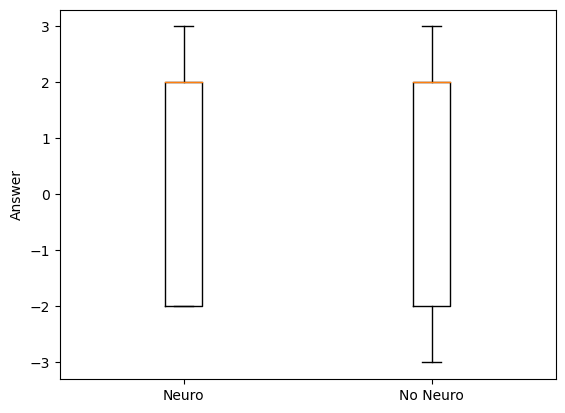

In [62]:
#get all good values and all bad values from Answer in seperate np arrays
NoNeuro = df[df['NoNeuro'] == 1]['Answer'].values
Neuro = df[df['NoNeuro'] == 0]['Answer'].values
#make a boxplot of the two arrays
plt.boxplot([Neuro, NoNeuro])
plt.xticks([1, 2], ['Neuro', 'No Neuro'])
plt.ylabel('Answer')
plt.show()

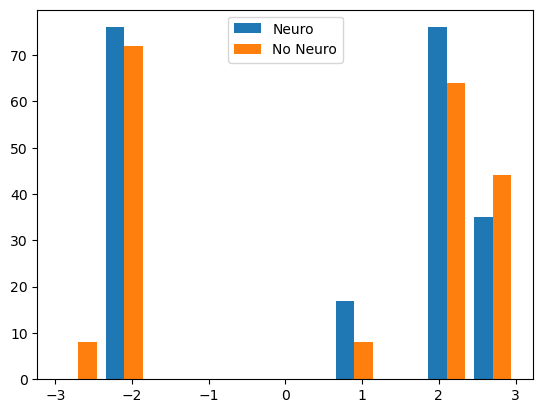

In [63]:
#bar plot of the counts of good and bad answers
plt.hist([Neuro, NoNeuro], label = ['Neuro', 'No Neuro'])
plt.legend()
plt.show()

Really does not seem like there is much of an effect. Seem pretty balanced. 

In [64]:
#t-test for difference in means
ttest_good_bad = ttest_ind(df[df['NoNeuro'] == 1]['Answer'], df[df['NoNeuro'] == 0]['Answer'])
#regression for difference in means
x = df['NoNeuro']
y = df['Answer']
x = sm.add_constant(x)
reg_long_short = sm.OLS(y, x).fit(cov_type = 'HC3')
#print answer
print(ttest_good_bad)
print(reg_long_short.summary())

Ttest_indResult(statistic=-0.4088691707070054, pvalue=0.6828555915420673)
                            OLS Regression Results                            
Dep. Variable:                 Answer   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.002
Method:                 Least Squares   F-statistic:                    0.1658
Date:                Mon, 01 May 2023   Prob (F-statistic):              0.684
Time:                        13:22:06   Log-Likelihood:                -872.35
No. Observations:                 400   AIC:                             1749.
Df Residuals:                     398   BIC:                             1757.
Df Model:                           1                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------

No difference between the groups. 

## Analysis combined
Here I will use multiple regression models instead of splitting the data up per groups to assess the interplay of the variables. 

In [65]:
#regression with all variables answer good, long, noneuro
x = df_ohe[['Answer Good', 'Long', 'NoNeuro']]
y = df_ohe['Answer']
x = sm.add_constant(x)
reg_1 = sm.OLS(y, x).fit(cov_type = 'HC3')
#print answer
print(reg_1.summary())

                            OLS Regression Results                            
Dep. Variable:                 Answer   R-squared:                       0.181
Model:                            OLS   Adj. R-squared:                  0.175
Method:                 Least Squares   F-statistic:                     30.47
Date:                Mon, 01 May 2023   Prob (F-statistic):           9.63e-18
Time:                        13:30:48   Log-Likelihood:                -832.56
No. Observations:                 400   AIC:                             1673.
Df Residuals:                     396   BIC:                             1689.
Df Model:                           3                                         
Covariance Type:                  HC3                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -0.5728      0.203     -2.820      

Good answer and long seem to have an effect on how to judge a response. 

In [69]:
#add 2 way interaction terms
df_ohe['Answer Good:Long'] = df_ohe['Answer Good'] * df_ohe['Long']
df_ohe['Answer Good:NoNeuro'] = df_ohe['Answer Good'] * df_ohe['NoNeuro']
df_ohe['Long:NoNeuro'] = df_ohe['Long'] * df_ohe['NoNeuro']



x = df_ohe[['Answer Good', 'Long', 'NoNeuro', 'Answer Good:Long', 'Answer Good:NoNeuro', 'Long:NoNeuro']]
y = df_ohe['Answer']
x = sm.add_constant(x)
reg_2 = sm.OLS(y, x).fit(cov_type = 'HC3')
#print answer
print(reg_2.summary())

                            OLS Regression Results                            
Dep. Variable:                 Answer   R-squared:                       0.200
Model:                            OLS   Adj. R-squared:                  0.188
Method:                 Least Squares   F-statistic:                     19.13
Date:                Mon, 01 May 2023   Prob (F-statistic):           1.40e-19
Time:                        13:43:06   Log-Likelihood:                -827.87
No. Observations:                 400   AIC:                             1670.
Df Residuals:                     393   BIC:                             1698.
Df Model:                           6                                         
Covariance Type:                  HC3                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -1.0738    

In [70]:
#3 way interaction term
df_ohe['Answer Good:Long:NoNeuro'] = df_ohe['Answer Good'] * df_ohe['Long'] * df_ohe['NoNeuro']


x = df_ohe[['Answer Good', 'Long', 'NoNeuro', 'Answer Good:Long', 'Answer Good:NoNeuro', 'Long:NoNeuro', 'Answer Good:Long:NoNeuro']]
y = df_ohe['Answer']
x = sm.add_constant(x)
reg_3 = sm.OLS(y, x).fit(cov_type = 'HC3')
#print answer
print(reg_3.summary())

                            OLS Regression Results                            
Dep. Variable:                 Answer   R-squared:                       0.210
Model:                            OLS   Adj. R-squared:                  0.195
Method:                 Least Squares   F-statistic:                     19.07
Date:                Mon, 01 May 2023   Prob (F-statistic):           6.32e-22
Time:                        13:43:15   Log-Likelihood:                -825.39
No. Observations:                 400   AIC:                             1667.
Df Residuals:                     392   BIC:                             1699.
Df Model:                           7                                         
Covariance Type:                  HC3                                         
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   